# Quantum annealing time evolution
## Albert Molina

Here I will be coding my Hamiltonians and time evolution for the p-shell nuclei studied in the paper ($^{8}Be, ^{10}Be, ^{12}Be$)

In [387]:
import scipy as sp
import numpy as np
from scipy.sparse.linalg import eigsh, expm_multiply
from scipy.linalg import eigvalsh 
import matplotlib.pyplot as plt
from src.hamiltonian_utils import FermiHubbardHamiltonian # the many-body Hamiltonian class
from src.nuclear_physics_utils import SingleParticleState,J2operator,get_twobody_nuclearshell_model # routines and class useful for the nuclear part

In [388]:
p_shell = 'data/cki'

SPS = SingleParticleState(file_name = p_shell)

# Let's print the single particle energies
print('single particle energies =', SPS.energies)
print('mapping between nucleon modes a and quantum numbers:', SPS.state_encoding)

nuc_modes_per_i = SPS.energies.shape[0] // 2   # counting per species!!

single particle energies = [1.63 1.63 1.63 1.63 2.27 2.27 1.63 1.63 1.63 1.63 2.27 2.27]
mapping between nucleon modes a and quantum numbers: [(0, 1, 1.5, -1.5, 0.5, 0.5), (0, 1, 1.5, -0.5, 0.5, 0.5), (0, 1, 1.5, 0.5, 0.5, 0.5), (0, 1, 1.5, 1.5, 0.5, 0.5), (0, 1, 0.5, -0.5, 0.5, 0.5), (0, 1, 0.5, 0.5, 0.5, 0.5), (0, 1, 1.5, -1.5, 0.5, -0.5), (0, 1, 1.5, -0.5, 0.5, -0.5), (0, 1, 1.5, 0.5, 0.5, -0.5), (0, 1, 1.5, 1.5, 0.5, -0.5), (0, 1, 0.5, -0.5, 0.5, -0.5), (0, 1, 0.5, 0.5, 0.5, -0.5)]


## $^{8}Be$

Now, let us initialize our Target Hamiltonian $\rightarrow$ NSM Hamiltonian for $^{8}Be$

In [389]:
# Let's start with 8-Be (2 protons and 2 neutrons in p-shell):
p = 2
n_eight = 2

NSM_H_eight = FermiHubbardHamiltonian(size_a=nuc_modes_per_i, size_b=nuc_modes_per_i, nparticles_a=p, nparticles_b=n_eight, 
                                symmetries=[SPS.total_M_zero]) # we force M=0 so we don't get the full manybody basis
# Also, I changed Ema's code where a was neutrons and b protons, since they're just numbers (and the same in this case)

NSM_H_eight.get_external_potential(external_potential=SPS.energies)
twobody_dict_eight, _ = get_twobody_nuclearshell_model(file_name=p_shell)

NSM_H_eight.get_twobody_interaction(twobody_dict_eight)
NSM_H_eight.get_hamiltonian() # Now we have the Target Hamiltonian ready

egs_eight, psigs_eight = NSM_H_eight.get_spectrum(n_states=1) # just the ground state (energy in MeV's)
print(f'GS energy = {egs_eight[0]:.5} MeV')
print(NSM_H_eight.hamiltonian)


Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  7.95it/s]
1424it [00:02, 575.80it/s]

GS energy = -30.295 MeV
  (0, 0)	-6.582989999999999
  (0, 1)	2.002499032786363
  (0, 2)	-2.315995000000001
  (0, 3)	0.17580399459981977
  (0, 4)	-0.10150048360681718
  (0, 5)	-1.052265
  (0, 6)	1.9530200000000002
  (0, 8)	1.9009985491795476
  (0, 10)	2.002499032786366
  (0, 11)	-1.7096958900278656
  (0, 12)	-0.10150048360681718
  (0, 13)	0.5966341818903774
  (0, 14)	2.054162795550007
  (0, 15)	1.9530199999999995
  (0, 16)	-1.0522650000000002
  (0, 18)	-1.9009985491795478
  (0, 20)	-0.9007550000000002
  (0, 23)	0.17580399459982032
  (0, 24)	1.3652289845057242
  (0, 25)	0.5966341818903769
  (0, 26)	1.9009985491795474
  (0, 27)	-1.9009985491795478
  (0, 29)	-2.3986297010721485
  (1, 0)	2.002499032786363
  (1, 1)	-5.3826374999999995
  :	:
  (49, 49)	-3.0554875000000017
  (49, 50)	1.1102230246251565e-16
  (50, 9)	-3.763858685577873
  (50, 11)	-2.3986297010721485
  (50, 13)	0.5966341818903769
  (50, 14)	1.3652289845057242
  (50, 19)	3.763858685577873
  (50, 24)	2.054162795550007
  (50, 25)	0

Now, let's get our Driver Hamiltonian.

We have to consider the initial state, which in this case is the minimum energy Slater determinant.

In [390]:
# We select the product state of the basis that minimizes the Hamiltonian
min = 10000
min_b_eight = 0.

for i, b in enumerate(NSM_H_eight.basis):
    psi = np.zeros(NSM_H_eight.basis.shape[0]) # we initialize the state
    psi[i] = 1.0
    val = np.conj(psi) @ NSM_H_eight.hamiltonian @ psi
    if val < min:
        min = val # Minimum energy!
        psi_base = psi 
        min_b_eight = b
print('MINIMUM BASIS:',min_b_eight) # THIS is the minimum energy Slater determinant
psi_ini_eight = psi_base.copy()

MINIMUM BASIS: [1 0 0 1 0 0 1 0 0 1 0 0]


Then we define our external potential, following the description from the paper

In [391]:
ext_pot_eight = np.zeros(2 * nuc_modes_per_i)
ext_pot_eight = (min / (p + n_eight)) * min_b_eight

We can initialize our Driver Hamiltonian

In [392]:
Driver_H_eight = FermiHubbardHamiltonian(size_a=nuc_modes_per_i, size_b=nuc_modes_per_i, nparticles_a=p, nparticles_b=n_eight, 
                                        symmetries=[SPS.total_M_zero])
Driver_H_eight.get_external_potential(ext_pot_eight)
Driver_H_eight.get_hamiltonian()
print(Driver_H_eight.hamiltonian)

  (0, 0)	-7.702854999999998
  (1, 1)	-7.702854999999998
  (2, 2)	-7.702854999999998
  (3, 3)	-3.851427499999999
  (4, 4)	-7.702854999999998
  (5, 5)	-15.405709999999996
  (6, 6)	-7.702854999999998
  (7, 7)	-7.702854999999998
  (8, 8)	-7.702854999999998
  (9, 9)	-7.702854999999998
  (10, 10)	-7.702854999999998
  (11, 11)	-7.702854999999998
  (12, 12)	-7.702854999999998
  (13, 13)	-3.851427499999999
  (14, 14)	-7.702854999999998
  (15, 15)	-7.702854999999998
  (20, 20)	-7.702854999999998
  (21, 21)	-7.702854999999998
  (22, 22)	-3.851427499999999
  (23, 23)	-3.851427499999999
  (25, 25)	-3.851427499999999
  (26, 26)	-7.702854999999998
  (31, 31)	-7.702854999999998
  (32, 32)	-7.702854999999998
  (33, 33)	-7.702854999999998
  (38, 38)	-3.851427499999999
  (39, 39)	-3.851427499999999
  (41, 41)	-7.702854999999998
  (42, 42)	-7.702854999999998
  (43, 43)	-3.851427499999999
  (44, 44)	-7.702854999999998
  (45, 45)	-7.702854999999998
  (46, 46)	-7.702854999999998


Now, let's perform the adiabatic evolution

(51, 51)
-30.291376100358363


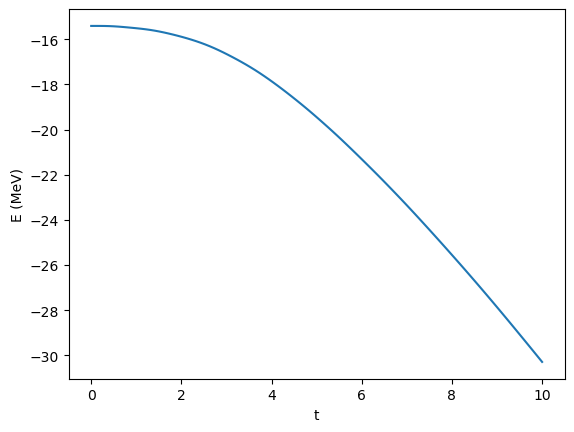

In [393]:
tf = 10
tsteps = 100
dt = tf / tsteps
time = np.linspace(0, tf, tsteps)

psi_eight = psi_ini_eight.copy()
energy_eight = []
spectrum_t_eight = []

for i, t in enumerate(time):
    H_t_eight = (1 - t/tf) * Driver_H_eight.hamiltonian + (t/tf) * NSM_H_eight.hamiltonian
    energy_eight.append(psi_eight.conjugate().transpose().dot(H_t_eight.dot(psi_eight))) # we append <psi(t)|H(t)|psi(t)>
    eigval_eight = eigsh(H_t_eight, k=1, return_eigenvectors=False)
    spectrum_t_eight.append(eigval_eight)
    psi_eight = expm_multiply(-1j * dt * H_t_eight,psi_eight)
spectrum_arr = np.asarray(spectrum_t_eight)
print(np.shape(H_t_eight))
# We plot the energy along time
plt.figure()
plt.plot(time, energy_eight)
plt.xlabel('t')
plt.ylabel('E (MeV)')
print(np.real(energy_eight[tsteps-1]))

We see that the energy at the end of the process is the same as the GS energy of the NSM $\rightarrow$ well executed!

Finally, let's compare the plot above with part of the spectrum of $H(t)$

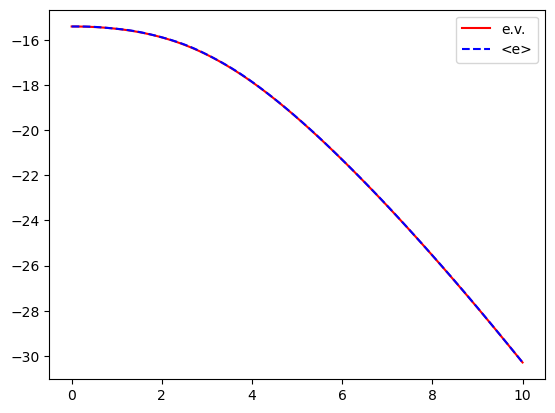

In [394]:
plt.figure()
plt.plot(time, spectrum_t_eight, 'r-', label='e.v.')
plt.plot(time, energy_eight, 'b--', label='<e>')
plt.legend()

## $^{10}Be$

In [395]:
# 10-Be (2 protons and 4 neutrons in p-shell):
p = 2
n_ten = 4

NSM_H_ten = FermiHubbardHamiltonian(size_a=nuc_modes_per_i, size_b=nuc_modes_per_i, nparticles_a=p, nparticles_b=n_ten, 
                                symmetries=[SPS.total_M_zero]) # we force M=0 so we don't get the full manybody basis
# Also, I changed Ema's code where a was neutrons and b protons, since they're just numbers (and the same in this case)

NSM_H_ten.get_external_potential(external_potential=SPS.energies)
twobody_dict_ten, _ = get_twobody_nuclearshell_model(file_name=p_shell)

NSM_H_ten.get_twobody_interaction(twobody_dict_ten)
NSM_H_ten.get_hamiltonian() # Now we have the Target Hamiltonian ready

egs, psigs = NSM_H_ten.get_spectrum(n_states=1) # just the ground state (energy in MeV's)
print(f'GS energy = {egs[0]:.5} MeV')
print(NSM_H_ten.hamiltonian)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  7.92it/s]
1424it [00:02, 573.41it/s]


GS energy = -39.453 MeV
  (0, 0)	-21.4277125
  (0, 1)	-2.002499032786364
  (0, 2)	-1.22563379245189
  (0, 3)	0.07702499999999957
  (0, 4)	-0.10150048360681718
  (0, 5)	1.9009985491795478
  (0, 6)	1.052265
  (0, 9)	1.9009985491795476
  (0, 10)	0.6106036802941635
  (0, 11)	-0.6889338110442829
  (0, 12)	1.5584110388469397
  (0, 13)	-0.49214631970583694
  (0, 14)	2.054162795550007
  (0, 15)	-1.9009985491795476
  (0, 16)	-1.9530199999999995
  (0, 19)	-1.9009985491795478
  (0, 20)	0.9007550000000002
  (0, 23)	1.10275
  (0, 24)	0.8524224304885455
  (0, 25)	0.5966341818903769
  (0, 26)	-3.1602874999999995
  (0, 27)	-1.9009985491795474
  (0, 30)	-2.3986297010721485
  (1, 0)	-2.002499032786364
  (1, 1)	-14.222665000000017
  :	:
  (49, 47)	-1.1027500000000003
  (49, 48)	-1.102749999999999
  (49, 49)	-13.622775000000008
  (49, 50)	1.043099999999999
  (50, 9)	-3.763858685577873
  (50, 10)	-2.3986297010721485
  (50, 11)	-1.9009985491795478
  (50, 13)	1.3652289845057242
  (50, 14)	0.7982485491795479


Driver Hamiltonian for $^{10}Be$

In [396]:
# We select the product state of the basis that minimizes the Hamiltonian
min = 10000
min_b = 0.

for i, b in enumerate(NSM_H_ten.basis):
    psi = np.zeros(NSM_H_ten.basis.shape[0]) # we initialize the state
    psi[i] = 1.0
    val = np.conj(psi) @ NSM_H_ten.hamiltonian @ psi
    if val < min:
        min = val # Minimum energy!
        psi_base = psi 
        min_b_ten = b
print('MINIMUM BASIS:',min_b_ten) # THIS is the minimum energy Slater determinant
psi_ini_ten = psi_base.copy()

# Get the external potential
ext_pot_ten = np.zeros(2 * nuc_modes_per_i)
ext_pot_ten = (min / (p + n_ten)) * min_b_ten

# Now we get the Driver Hamiltonian
Driver_H_ten = FermiHubbardHamiltonian(size_a=nuc_modes_per_i, size_b=nuc_modes_per_i, nparticles_a=p, nparticles_b=n_ten, 
                                   symmetries=[SPS.total_M_zero])
Driver_H_ten.get_external_potential(ext_pot_ten)
Driver_H_ten.get_hamiltonian()
print(Driver_H_ten.hamiltonian)

MINIMUM BASIS: [1 0 0 1 0 0 1 1 1 1 0 0]
  (0, 0)	-19.309833333333348
  (1, 1)	-14.482375000000012
  (2, 2)	-19.309833333333348
  (3, 3)	-19.309833333333348
  (4, 4)	-14.482375000000012
  (5, 5)	-28.96475000000002
  (6, 6)	-24.137291666666684
  (7, 7)	-24.137291666666684
  (8, 8)	-19.309833333333348
  (9, 9)	-19.309833333333348
  (10, 10)	-19.309833333333348
  (11, 11)	-14.482375000000012
  (12, 12)	-19.309833333333348
  (13, 13)	-19.309833333333348
  (14, 14)	-14.482375000000012
  (15, 15)	-19.309833333333348
  (16, 16)	-14.482375000000012
  (17, 17)	-14.482375000000012
  (18, 18)	-9.654916666666674
  (19, 19)	-9.654916666666674
  (20, 20)	-19.309833333333348
  (21, 21)	-19.309833333333348
  (22, 22)	-14.482375000000012
  (23, 23)	-14.482375000000012
  (24, 24)	-14.482375000000012
  :	:
  (26, 26)	-19.309833333333348
  (27, 27)	-14.482375000000012
  (28, 28)	-14.482375000000012
  (29, 29)	-9.654916666666674
  (30, 30)	-9.654916666666674
  (31, 31)	-19.309833333333348
  (32, 32)	-14.48

Now we perform the adiabatic evolution on $^{10}Be$

(100, 1)
-39.44968602416988


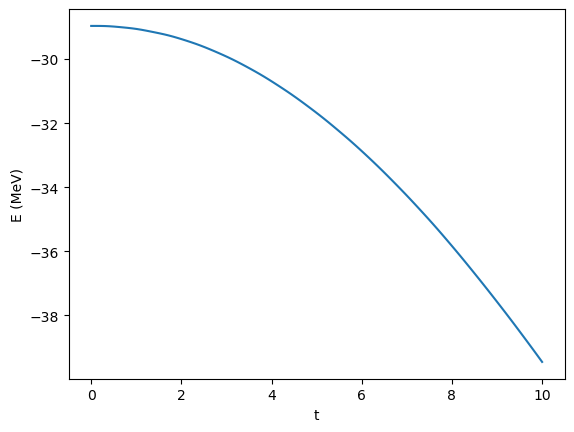

In [397]:
tf = 10
tsteps = 100
dt = tf / tsteps
time = np.linspace(0, tf, tsteps)

psi_ten = psi_ini_ten.copy()
energy_ten = []
spectrum_t_ten = []

for i, t in enumerate(time):
    H_t_ten = (1 - t/tf) * Driver_H_ten.hamiltonian + (t/tf) * NSM_H_ten.hamiltonian
    energy_ten.append(psi_ten.conjugate().transpose().dot(H_t_ten.dot(psi_ten))) # we append <psi|H(t)|psi>
    eigval_ten = eigsh(H_t_ten, k=1, return_eigenvectors=False)
    spectrum_t_ten.append(eigval_ten)
    psi_ten = expm_multiply(-1j * dt * H_t_ten,psi_ten)
spectrum_arr_ten = np.asarray(spectrum_t_ten)
print(spectrum_arr_ten.shape)

# We plot the energy along time
plt.figure()
plt.plot(time, energy_ten)
plt.xlabel('t')
plt.ylabel('E (MeV)')
print(np.real(energy_ten[tsteps-1]))

We see that the energy at the end of the process is the same as the GS energy of the NSM $\rightarrow$ well executed!

Finally, let's compare the plot above with part of the spectrum of $H(t)$

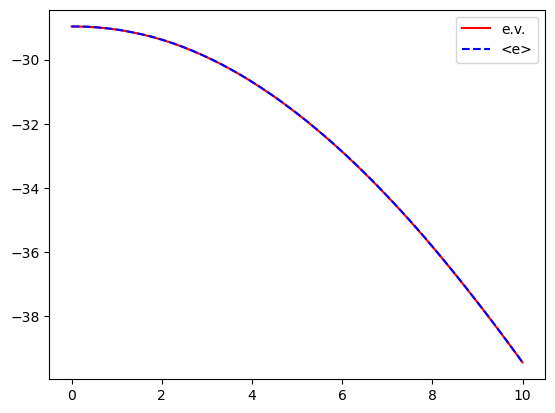

In [398]:
plt.figure()
plt.plot(time, spectrum_t_ten, 'r-', label='e.v.')
plt.plot(time, energy_ten, 'b--', label='<e>')
plt.legend()

## $^{12}Be$

In [399]:
# 12-Be (2 protons and 6 neutrons in p-shell):
p = 2
n_twelve = 6

NSM_H_twelve = FermiHubbardHamiltonian(size_a=nuc_modes_per_i, size_b=nuc_modes_per_i, nparticles_a=p, nparticles_b=n_twelve, 
                                symmetries=[SPS.total_M_zero]) # we force M=0 so we don't get the full manybody basis
# Also, I changed Ema's code where a was neutrons and b protons, since they're just numbers (and the same in this case)

NSM_H_twelve.get_external_potential(external_potential=SPS.energies)
twobody_dict_twelve, _ = get_twobody_nuclearshell_model(file_name=p_shell)

NSM_H_twelve.get_twobody_interaction(twobody_dict_twelve)
NSM_H_twelve.get_hamiltonian() # Now we have the Target Hamiltonian ready

egs, psigs = NSM_H_twelve.get_spectrum(n_states=1) # just the ground state (energy in MeV's)
print(f'GS energy = {egs[0]:.5} MeV')
print(NSM_H_twelve.hamiltonian)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  8.09it/s]
1424it [00:01, 781.97it/s]

GS energy = -41.221 MeV
  (0, 0)	-38.16192500000004
  (0, 1)	1.0430999999999995
  (0, 2)	1.1027500000000001
  (0, 3)	1.1027500000000001
  (0, 4)	-3.763858685577873
  (1, 0)	1.0430999999999995
  (1, 1)	-38.16192500000007
  (1, 2)	1.1027500000000008
  (1, 3)	1.1027500000000001
  (1, 4)	3.763858685577873
  (2, 0)	1.1027500000000001
  (2, 1)	1.1027500000000008
  (2, 2)	-32.12878750000006
  (2, 3)	-1.0019
  (2, 4)	1.942890293094024e-16
  (3, 0)	1.1027500000000001
  (3, 1)	1.1027500000000001
  (3, 2)	-1.0019
  (3, 3)	-32.12878750000006
  (3, 4)	-5.828670879282072e-16
  (4, 0)	-3.763858685577873
  (4, 1)	3.763858685577873
  (4, 2)	1.942890293094024e-16
  (4, 3)	-5.828670879282072e-16
  (4, 4)	-27.17025000000005


Driver Hamiltonian for $^{12}Be$

In [400]:
# We select the product state of the basis that minimizes the Hamiltonian
min = 10000
min_b = 0.

for i, b in enumerate(NSM_H_twelve.basis):
    psi = np.zeros(NSM_H_twelve.basis.shape[0]) # we initialize the state
    psi[i] = 1.0
    val = np.conj(psi) @ NSM_H_twelve.hamiltonian @ psi
    if val < min:
        min = val # Minimum energy!
        psi_base = psi 
        min_b_twelve = b
print('MINIMUM BASIS:',min_b_twelve) # THIS is the minimum energy Slater determinant
psi_ini_twelve = psi_base.copy()

# Get the external potential
ext_pot_twelve = np.zeros(2 * nuc_modes_per_i)
ext_pot_twelve = (min / (p + n_twelve)) * min_b_twelve

# Now we get the Driver Hamiltonian
Driver_H_twelve = FermiHubbardHamiltonian(size_a=nuc_modes_per_i, size_b=nuc_modes_per_i, nparticles_a=p, nparticles_b=n_twelve, 
                                   symmetries=[SPS.total_M_zero])
Driver_H_twelve.get_external_potential(ext_pot_twelve)
Driver_H_twelve.get_hamiltonian()
print(Driver_H_twelve.hamiltonian)

MINIMUM BASIS: [0 1 1 0 0 0 1 1 1 1 1 1]
  (0, 0)	-28.621443750000047
  (1, 1)	-38.16192500000006
  (2, 2)	-33.391684375000054
  (3, 3)	-33.391684375000054
  (4, 4)	-28.621443750000047


Now we perform the adiabatic evolution on $^{12}Be$

-41.21638666472016


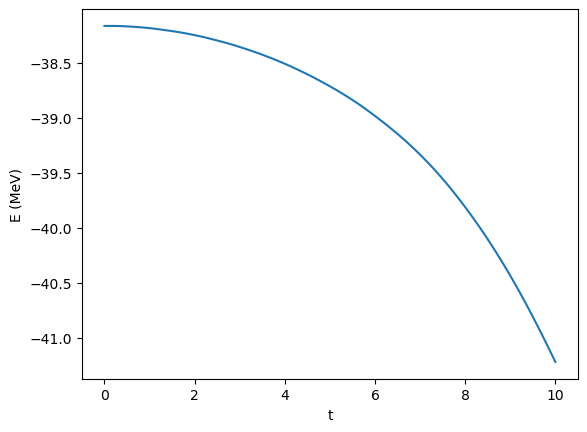

In [401]:
tf = 10
tsteps = 100
dt = tf / tsteps
time = np.linspace(0, tf, tsteps)

psi_twelve = psi_ini_twelve.copy()
energy_twelve = []
spectrum_t_twelve = []

for i, t in enumerate(time):
    H_t_twelve = (1 - t/tf) * Driver_H_twelve.hamiltonian + (t/tf) * NSM_H_twelve.hamiltonian
    energy_twelve.append(psi_twelve.conjugate().transpose().dot(H_t_twelve.dot(psi_twelve))) # we append <psi|H(t)|psi>
    eigval_twelve = eigsh(H_t_twelve, k=1, return_eigenvectors=False)
    spectrum_t_twelve.append(eigval_twelve)
    psi_twelve = expm_multiply(-1j * dt * H_t_twelve,psi_twelve)
spectrum_arr = np.asarray(spectrum_t_twelve)

# We plot the energy along time
plt.figure()
plt.plot(time, energy_twelve)
plt.xlabel('t')
plt.ylabel('E (MeV)')
print(np.real(energy_twelve[tsteps-1]))

We see that the energy at the end of the process is approx. the same as the GS energy of the NSM $\rightarrow$ well executed!

Finally, let's compare the plot above with part of the spectrum of $H(t)$

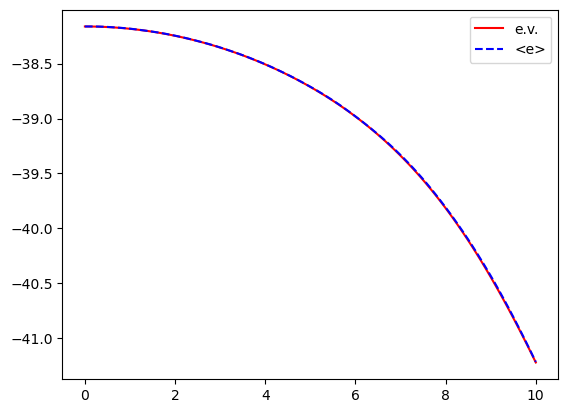

In [402]:
plt.figure()
plt.plot(time, spectrum_t_twelve, 'r-', label='e.v.')
plt.plot(time, energy_twelve, 'b--', label='<e>')
plt.legend()